# Base forecaster against historical questions

## Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from load_research import load_research
from prompt_question importprompt_question
from query_perplexity_with_date_filter import query_perplexity_with_date_filter
from predict import predict
import os
import numpy as np
from extract_forecast import extract_forecast

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [2]:
from load_secrets import load_secrets
load_secrets()

## Historical data

In [ ]:
df = pd.read_json('resolved.json')

In [ ]:
df['research'] = df.apply(load_research, axis=1)

In [ ]:
df['today'] = df.apply(lambda row: row.open_time.date().strftime("%Y-%m-%d"), axis=1)

## Prompts

### Binary

In [ ]:
question_binary = df[df.question_type == 'binary'].iloc[0]
print(prompt_binary(question_binary))

### Multiple Choice

In [ ]:
question_multiple_choice = df[df.question_type == 'multiple_choice'].iloc[0]
print(prompt_multiple_choice(question_multiple_choice))

### Numeric question

In [ ]:
question_numeric = df[df.question_type == 'numeric'].iloc[0]
print(prompt_numeric(question_numeric))

In [ ]:
prompt_funs = {x: eval(f'prompt_{x}') for x in df.question_type.unique()}
prompt_funs

In [ ]:
df['prompt'] = df.apply(prompt_question, axis=1)

## Historical benchmark

### Forecast all questions

In [ ]:
question = df.iloc[0]

In [ ]:
prompt = question.prompt

In [ ]:
question.today

In [ ]:
dfn = 'forecast'
os.makedirs(dfn, exist_ok=True)

In [ ]:
!pwd

In [ ]:
df['forecast'] = df.progress_apply(lambda question: predict(dfn, question), axis=1)

In [ ]:
df.to_json('wow.json')

### Reload all forecasts

In [ ]:
df = pd.read_json('wow.json')

### Extract the answer

### Binary

In [ ]:
question = df[df.id == 37008].iloc[0]
question

In [ ]:
print(question.forecast)

In [ ]:
extract_probability(question)

In [ ]:
question = df[df.id == 35190].iloc[0]
question

In [ ]:
question = df[df.id == 36168].iloc[0]

In [ ]:
extract_probability(question)

### Numeric

In [ ]:
question = df[df.id == 36164].iloc[0]

In [ ]:
extract_percentiles(question)

In [ ]:
question = df.iloc[0]

In [ ]:
extract_percentiles(question)

In [ ]:
print(df.iloc[0].question_resolution)

In [ ]:
question = df[df.id == 35678].iloc[0]

In [ ]:
extract_percentiles(question)

### Multiple choice

In [ ]:
question = df[df.question_type == 'multiple_choice'].iloc[0]

In [ ]:
print(question.forecast)

In [ ]:
question.question_options

In [ ]:
question.question_resolution

In [ ]:
text, question_options = question.forecast, eval(question.question_options)

In [ ]:
extract_probabilities(text, question_options, '')

In [ ]:
question = df[df.id == 36264].iloc[0]

In [ ]:
print(question.forecast)

In [ ]:
print(question.question_options)

In [ ]:
extract_multiple_choice(question)

In [ ]:
question = df[df.id == 36168].iloc[0]

In [ ]:
extract_multiple_choice(question)

In [ ]:
question.question_options

In [ ]:
print(question.forecast)

In [ ]:
extract_multiple_choice(question)

### All

In [ ]:
df['prediction'] = df.apply(extract_forecast, axis=1)

In [ ]:
df.to_json('run_with_predictions.json')

## Scoring rule

### Binary

In [ ]:
df[df.question_type == 'binary'].question_resolution.unique()

In [ ]:
question = df[df.question_type == 'binary'].iloc[0]

In [ ]:
question = df[df.id == 35190].iloc[0]
question

In [ ]:
question.question_resolution, question.prediction

In [ ]:
calculate_ubs_binary(question)

### Numeric

In [ ]:
question=df[df.id==35677].iloc[0]

In [ ]:
print(question.forecast)

In [ ]:
question.prediction

In [ ]:
calculate_ubs_numeric(question)

In [ ]:
question = df[df.question_type == 'numeric'].iloc[0]

In [ ]:
question

In [ ]:
print(question.question_resolution)

In [ ]:
calculate_ubs_numeric(question)

### Multiple choice

In [ ]:
question = df[df.question_type == 'multiple_choice'].iloc[0]

In [ ]:
question

In [ ]:
question.prediction, question.question_resolution

In [ ]:
calculate_ubs_multiclass(question)

In [ ]:
question = df[df.id == 36168].iloc[0]

In [ ]:
calculate_ubs_multiclass(question)

### All

In [ ]:
df['score'] = df.apply(calculate_ubs, axis=1)

In [ ]:
df.to_json('scored.json')

## Historical benchmark

In [6]:
df = pd.read_json('scored.json')

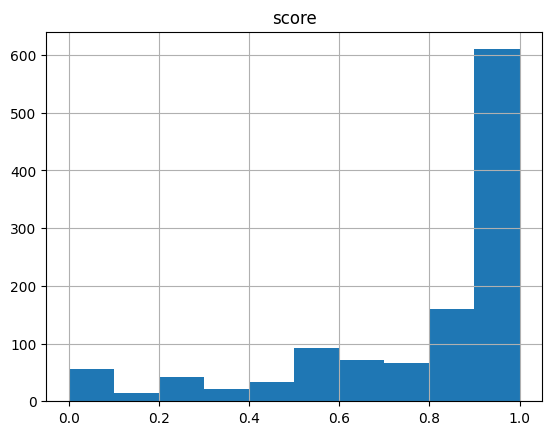

In [15]:
ax = df.hist(column='score', bins=10)
plt.show()  # explicitly show the plot

In [17]:
scores_by_date = df.sort_values(by='open_time')

In [19]:
scores_by_date.score.mean()

0.7859450342465754

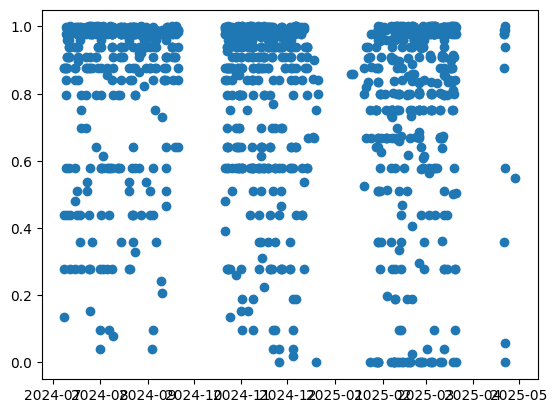

In [20]:
plt.scatter(scores_by_date.open_time, scores_by_date.score.values)

In [23]:
((scores_by_date.score-0.5).sum())/len(scores_by_date)

0.28594503424657536

In [28]:
scores_by_date[['id', 'open_time', 'title', 'score']].to_csv('readme.csv', index=False)

## Make it more RAGy, using the references in the prompt for possible deeper search

In [ ]:
df[df.id == 36164].iloc[0]